In [1]:
# Necessary imports
import os
import sys
import warnings

import numpy as np
warnings.filterwarnings("ignore")

sys.path.append('../..')
from seismiqb.src.controllers.torch_models import EncoderDecoder, ExtensionModel
from seismiqb import MODEL_CONFIG_DETECTION, MODEL_CONFIG_EXTENSION
from seismiqb.src.controllers import Interpolator, Extender

# Set GPU
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


Controllers are classes that wrap around train, inference and evaluation procedures in order to hold them in one place, with all the bells and whistles.

Each of them is configured with a nested dictionary, that describes how to use each of the methods.

In [2]:
# Global parameters
BAR = 't'

# Detection

In [3]:
!rm -rf controller_detection/

detection_config = {
    'savedir': 'controller_detection',
    'monitor': True,
    'bar': BAR,
    'plot': False,
    'train': {
        'model_class': EncoderDecoder,
        'model_config': MODEL_CONFIG_DETECTION,
        
        'batch_size': 64,
        'crop_shape': (1, 256, 256),

        'adaptive_slices': True,
        'grid_src': 'quality_grid',
        'side_view': False,
        'width': 3,

        'rebatch_threshold': 0.8,
        'rescale_batch_size': True,
        
        'prefetch': 3,
        'n_iters': 150,
        'early_stopping': True,
    },
    'inference': {
        'orientation': 'ix',
        'batch_size': 64,
        'crop_shape': (1, 256, 256),
        'overlap_factor': 1.3,
        'prefetch': 0,
        
        'chunk_size': 300,
        'chunk_overlap': 0.1,
    },
    'evaluate': {
        'n': 1,
        'supports': 100,
        'device': 'gpu',
        'dump': False,
    },
}

In [4]:
detector = Interpolator(detection_config)

In [5]:
%%time
dataset = detector.make_dataset(
    cube_paths='/data/seismic_data/seismic_interpretation/CUBE_01_ETP/amplitudes_01_ETP.hdf5',
    horizon_paths='/data/seismic_data/seismic_interpretation/CUBE_01_ETP/INPUTS/HORIZONS/RAW/etp_B_anon',
)

CPU times: user 3.45 s, sys: 522 ms, total: 3.97 s
Wall time: 3.9 s


In [6]:
%%time
model = detector.train(dataset=dataset, frequencies=(200, 200))

loss_history=0.103445: 100%|████████████████████████████| 150/150 [02:03<00:00,  1.22it/s]


CPU times: user 2min 14s, sys: 34.8 s, total: 2min 49s
Wall time: 2min 21s


In [7]:
%%time
prediction = detector.inference(dataset, model)

x-inference: 100%|████████████████████████████████| 6/6 [04:20<00:00, 43.46s/it]


CPU times: user 4min 54s, sys: 2min 56s, total: 7min 50s
Wall time: 8min 18s


In [8]:
prediction = detector.postprocess(prediction)

In [9]:
%%time
_ = detector.evaluate(prediction, dataset=dataset)

CPU times: user 22.8 s, sys: 8.01 s, total: 30.8 s
Wall time: 19.3 s


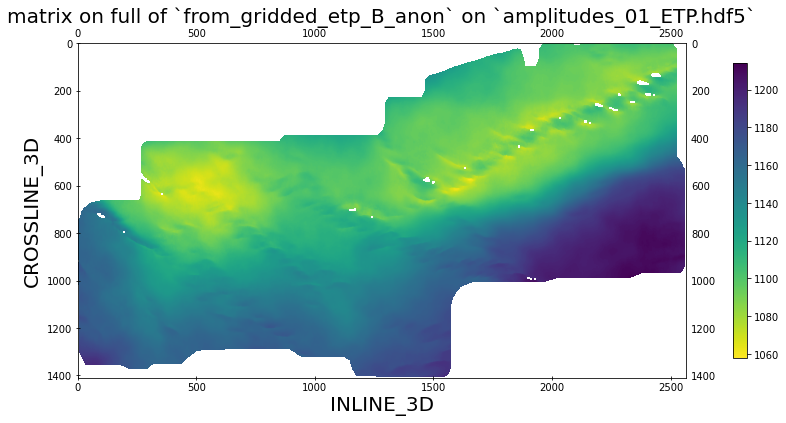

In [10]:
prediction.show()

# Extension

In [11]:
!rm -rf controller_extension/

config = {
    'savedir': 'controller_extension',
    'monitor': True,
    'bar': BAR,
    'plot': False,
    'sampler': {},
    'train': {
        'model_class': ExtensionModel,
        'model_config': MODEL_CONFIG_EXTENSION,
        
        'batch_size': 64,
        'crop_shape': (1, 128, 128),

        'adaptive_slices': False,
        'side_view': True,
        'width': 3,

        'rebatch_threshold': 0.8,
        'rescale_batch_size': True,
        
        'prefetch': 1,
        'n_iters': 150,
        'early_stopping': True,
    },
    'inference': {
        'batch_size': 128,
        'crop_shape': (1, 128, 128),
        'prefetch': 0,
        
        'n_steps': 32,
        'stride': 32,
    },
    'evaluate': {
        'n': 1,
        'supports': 100,
        'dump': False,
        'device': 'gpu',
    },
}

In [12]:
extender = Extender(config)

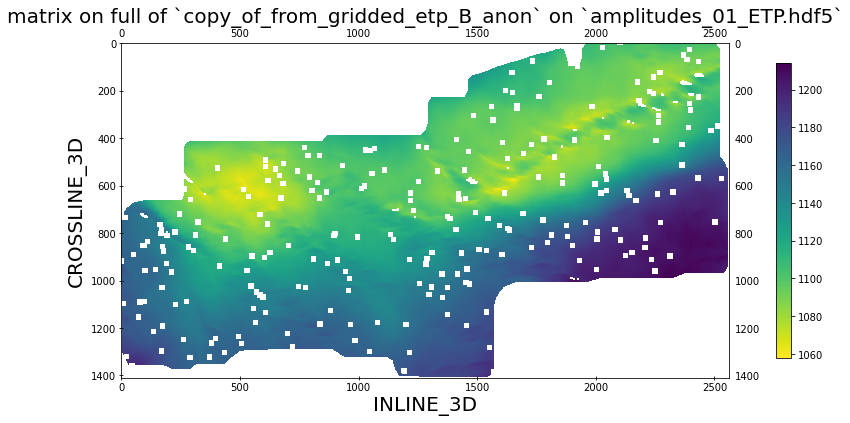

In [13]:
# Artificially add holes so that extension has to do some work
from scipy.ndimage.morphology import binary_dilation
horizon = prediction.__copy__()

matrix = np.random.binomial(1, 0.0001, size=horizon.geometry.zero_traces.shape)
structure = np.ones((3, 3))
matrix = binary_dilation(matrix, structure, iterations=7)
horizon.filter(filtering_matrix=matrix)
horizon.show()

In [14]:
%%time
model = extender.train(horizon=horizon)

loss_history=0.073004: 100%|████████████████████████████| 150/150 [01:35<00:00,  1.58it/s]


CPU times: user 1min 39s, sys: 38.8 s, total: 2min 18s
Wall time: 1min 45s


In [15]:
%%time
prediction = extender.inference(horizon, model)

Extender inference:  19%|████▌                   | 6/32 [03:49<16:35, 38.29s/it]


CPU times: user 2min 58s, sys: 24.5 s, total: 3min 23s
Wall time: 3min 53s


In [16]:
prediction = extender.postprocess(prediction)

In [17]:
%%time
_ = extender.evaluate(prediction, dataset=dataset)

CPU times: user 18 s, sys: 8.56 s, total: 26.6 s
Wall time: 14 s


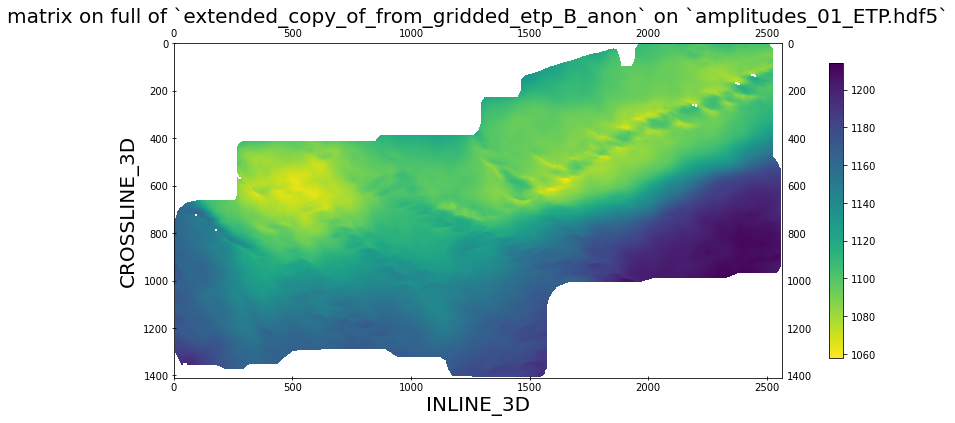

In [18]:
prediction.show()